# Fake news detection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Read datasets

In [2]:
fake = pd.read_csv("data/Fake.csv")
true = pd.read_csv("data/True.csv")

In [3]:
fake.shape

(23481, 4)

In [4]:
true.shape

(21417, 4)

## Data cleaning and preparation

In [5]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [6]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [7]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [8]:
# Check the data
data.head()

,title,text,subject,date,target
0,NEW YORK TIMES WEASEL Behind Alleged Comey Mem...,Got News- New York Times Mexican telecom mogu...,politics,"May 19, 2017",fake
1,One Person MURDERED Every 14 Hours In Obama’s ...,69 people were shot in gun-free Chicago over t...,left-news,"Jun 1, 2016",fake
2,"BOOM! WATCH TRUMP IN FLINT: “Now, the Cars are...",OUCH! Trump really put things in perspective w...,left-news,"Sep 15, 2016",fake
3,U.S. lawmakers say Afghanistan corruption thre...,WASHINGTON (Reuters) - U.S. senators questione...,politicsNews,"September 15, 2016",true
4,OOPS! NY GOV CUOMO Announces Statues of Confed...,Really Andrew? Does all of New York really sta...,politics,"Aug 17, 2017",fake


In [9]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,NEW YORK TIMES WEASEL Behind Alleged Comey Mem...,Got News- New York Times Mexican telecom mogu...,politics,fake
1,One Person MURDERED Every 14 Hours In Obama’s ...,69 people were shot in gun-free Chicago over t...,left-news,fake
2,"BOOM! WATCH TRUMP IN FLINT: “Now, the Cars are...",OUCH! Trump really put things in perspective w...,left-news,fake
3,U.S. lawmakers say Afghanistan corruption thre...,WASHINGTON (Reuters) - U.S. senators questione...,politicsNews,true
4,OOPS! NY GOV CUOMO Announces Statues of Confed...,Really Andrew? Does all of New York really sta...,politics,fake


In [10]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,Got News- New York Times Mexican telecom mogu...,politics,fake
1,69 people were shot in gun-free Chicago over t...,left-news,fake
2,OUCH! Trump really put things in perspective w...,left-news,fake
3,WASHINGTON (Reuters) - U.S. senators questione...,politicsNews,true
4,Really Andrew? Does all of New York really sta...,politics,fake


In [11]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,got news- new york times mexican telecom mogu...,politics,fake
1,69 people were shot in gun-free chicago over t...,left-news,fake
2,ouch! trump really put things in perspective w...,left-news,fake
3,washington (reuters) - u.s. senators questione...,politicsNews,true
4,really andrew? does all of new york really sta...,politics,fake


In [12]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [13]:
# Check
data.head()

,text,subject,target
0,got news new york times mexican telecom mogul...,politics,fake
1,69 people were shot in gunfree chicago over th...,left-news,fake
2,ouch trump really put things in perspective wh...,left-news,fake
3,washington reuters us senators questioned sta...,politicsNews,true
4,really andrew does all of new york really stan...,politics,fake


In [14]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ansh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
data.head()

,text,subject,target
0,got news new york times mexican telecom mogul ...,politics,fake
1,69 people shot gunfree chicago past memorial d...,left-news,fake
2,ouch trump really put things perspective visit...,left-news,fake
3,washington reuters us senators questioned stat...,politicsNews,true
4,really andrew new york really stand racism al ...,politics,fake


## Basic data exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


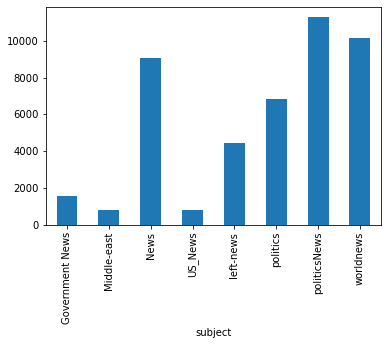

In [16]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


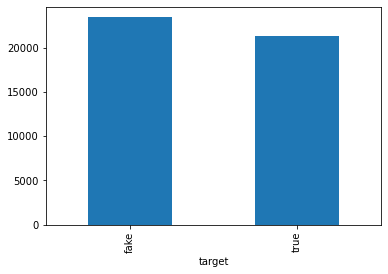

In [17]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

In [18]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

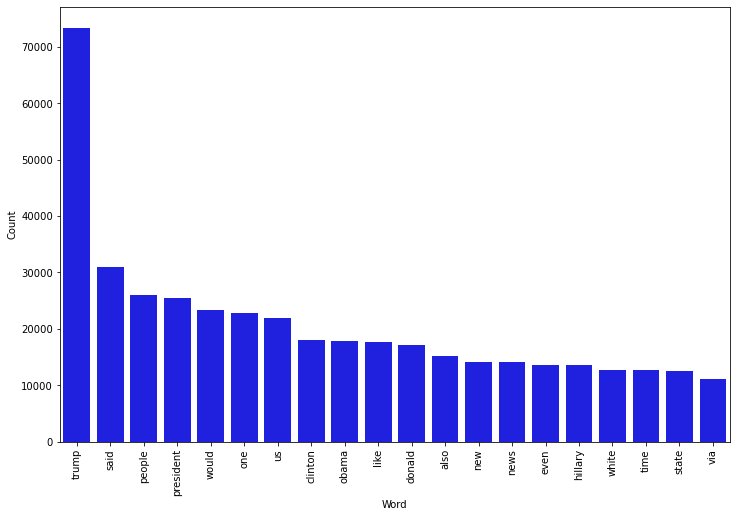

In [19]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

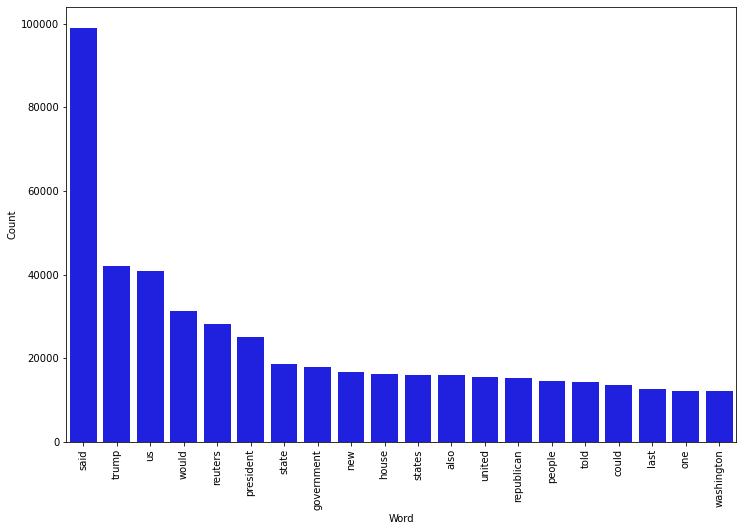

In [20]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

## Modeling

In [21]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Peparing the data

In [22]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

### Decision Tree Classifier

In [25]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.64%


Confusion matrix, without normalization


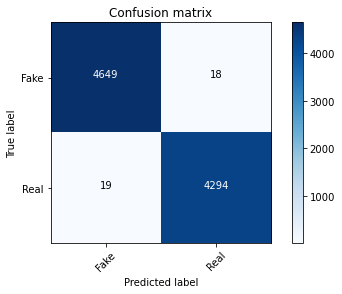

In [24]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])